In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd()
    # Hyperparameters
    num_classes = 100
    input_shape = (32, 32, 3)
    
    weight_decay = 0.0001
    learning_rate = 0.001
    label_smoothing = 0.1
    validation_split = 0.2
    batch_size = 128
    num_epochs = 100
    patch_size = 2  # Size of the patches to be extracted from the input images.
    num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
    embedding_dim = 64  # Number of hidden units.
    mlp_dim = 64
    dim_coefficient = 4
    num_heads = 4
    attention_dropout = 0.2
    projection_dropout = 0.2
    num_transformer_blocks = 8  # Number of repetitions of the transformer layer
    
    early_stopping_patience=10

In [2]:
#Standart libs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import backend as K

def set_seed(seed=42):
    # Set the Python hash seed
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    # Set the Python, Numpy and Tensorflow random seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    # Set deterministic options for Tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Limit Tensorflow to single thread for full reproducibility
    tf.config.threading.set_inter_op_parallelism_threads(1)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    print('seeding done!!!')
set_seed(CFG.SEED)


seeding done!!!


In [4]:
import tensorflow_addons as tfa

# Prepare the data

In [5]:


(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
y_train = tf.keras.utils.to_categorical(y_train, CFG.num_classes)
y_test = tf.keras.utils.to_categorical(y_test, CFG.num_classes)
print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
X_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


In [6]:
print(f"Patch size: {CFG.patch_size} X {CFG.patch_size} = {CFG.patch_size ** 2} ")
print(f"Patches per image: {CFG.num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 256


# Use data augmentation

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.1),
#         tf.keras.layers.RandomContrast(factor=0.1),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Implement the patch extraction and encoding layer

In [9]:
class PatchExtract(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = tf.keras.layers.Dense(embed_dim)
        self.pos_embed = tf.keras.layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

# Implement the external attention block

In [10]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = tf.keras.layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = tf.keras.layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = tf.keras.layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = tf.keras.layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = tf.keras.layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = tf.keras.layers.Dense(dim)(x)
    x = tf.keras.layers.Dropout(projection_dropout)(x)
    return x

# Implement the MLP block

In [11]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = tf.keras.layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)
    x = tf.keras.layers.Dense(embedding_dim)(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)
    return x

# Implement the Transformer block

In [12]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = tf.keras.layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = tf.keras.layers.add([x, residual_1])
    residual_2 = x
    x = tf.keras.layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = tf.keras.layers.add([x, residual_2])
    return x

# Implement the EANet model

In [13]:
def get_model(attention_type="external_attention"):
    inputs = tf.keras.layers.Input(shape=CFG.input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(CFG.patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(CFG.num_patches, CFG.embedding_dim)(x)
    # Create Transformer block.
    for _ in range(CFG.num_transformer_blocks):
        x = transformer_encoder(
            x,
            CFG.embedding_dim,
            CFG.mlp_dim,
            CFG.num_heads,
            CFG.dim_coefficient,
            CFG.attention_dropout,
            CFG.projection_dropout,
            attention_type,
        )

    x = tf.keras.layers.GlobalAvgPool1D()(x)
    outputs = tf.keras.layers.Dense(CFG.num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Train on CIFAR-100

In [14]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=CFG.learning_rate, weight_decay=CFG.weight_decay
    ),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
# Create a learning rate scheduler callback.
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                          factor=0.7,
                                                          min_delta=0.001,
                                                          patience=3,
                                                          mode="auto")
    
 # Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=CFG.early_stopping_patience,
        restore_best_weights=True,
        min_delta=0.001,
    )
history = model.fit(
    X_train,
    y_train,
    batch_size=CFG.batch_size,
    epochs=CFG.num_epochs,
    validation_split=CFG.validation_split,
    callbacks=[reduceLROnPlat, early_stopping],
)

_, accuracy, top_5_accuracy = history.model.evaluate(X_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

Epoch 1/100
313/313 [==============================] - 17s 39ms/step - loss: 4.2175 - accuracy: 0.0720 - top-5-accuracy: 0.2382 - val_loss: 3.9763 - val_accuracy: 0.1123 - val_top-5-accuracy: 0.3330 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 11s 36ms/step - loss: 3.7877 - accuracy: 0.1460 - top-5-accuracy: 0.3932 - val_loss: 3.6452 - val_accuracy: 0.1870 - val_top-5-accuracy: 0.4609 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 11s 37ms/step - loss: 3.5332 - accuracy: 0.2021 - top-5-accuracy: 0.4870 - val_loss: 3.4996 - val_accuracy: 0.2227 - val_top-5-accuracy: 0.5066 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 11s 37ms/step - loss: 3.3849 - accuracy: 0.2397 - top-5-accuracy: 0.5382 - val_loss: 3.4333 - val_accuracy: 0.2440 - val_top-5-accuracy: 0.5375 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 3.2873 - accuracy: 0.2632 - top-5-accuracy: 0.5697 - val_loss: 3.4031 - val

313/313 [==============================] - 11s 37ms/step - loss: 2.4741 - accuracy: 0.4779 - top-5-accuracy: 0.7907 - val_loss: 2.7958 - val_accuracy: 0.4229 - val_top-5-accuracy: 0.7408 - lr: 7.0000e-04
Epoch 40/100
313/313 [==============================] - 11s 37ms/step - loss: 2.4758 - accuracy: 0.4797 - top-5-accuracy: 0.7891 - val_loss: 2.8278 - val_accuracy: 0.4152 - val_top-5-accuracy: 0.7313 - lr: 7.0000e-04
Epoch 41/100
313/313 [==============================] - 11s 37ms/step - loss: 2.4753 - accuracy: 0.4790 - top-5-accuracy: 0.7889 - val_loss: 2.7950 - val_accuracy: 0.4250 - val_top-5-accuracy: 0.7430 - lr: 7.0000e-04
Epoch 42/100
313/313 [==============================] - 11s 37ms/step - loss: 2.4421 - accuracy: 0.4875 - top-5-accuracy: 0.7976 - val_loss: 2.7611 - val_accuracy: 0.4312 - val_top-5-accuracy: 0.7456 - lr: 4.9000e-04
Epoch 43/100
313/313 [==============================] - 11s 37ms/step - loss: 2.4438 - accuracy: 0.4857 - top-5-accuracy: 0.7980 - val_loss: 2.83

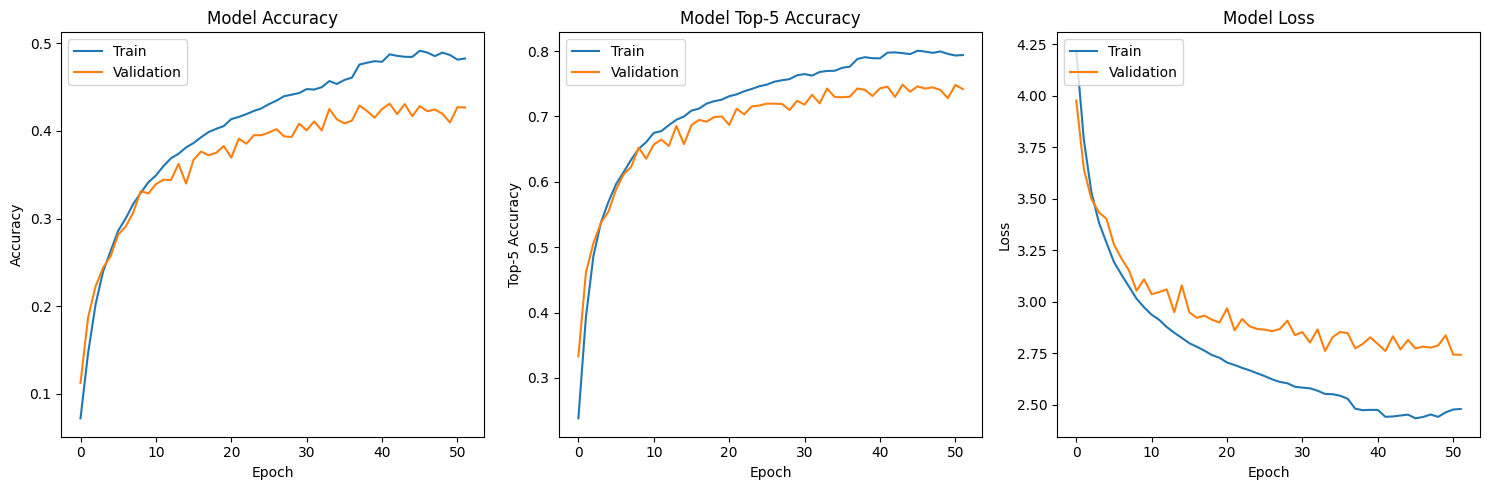

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # summarize history for top-5 accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['top-5-accuracy'])
    plt.plot(history.history['val_top-5-accuracy'])
    plt.title('Model Top-5 Accuracy')
    plt.ylabel('Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
plot_history(history)

1/1 [==============================] - 0s 17ms/step


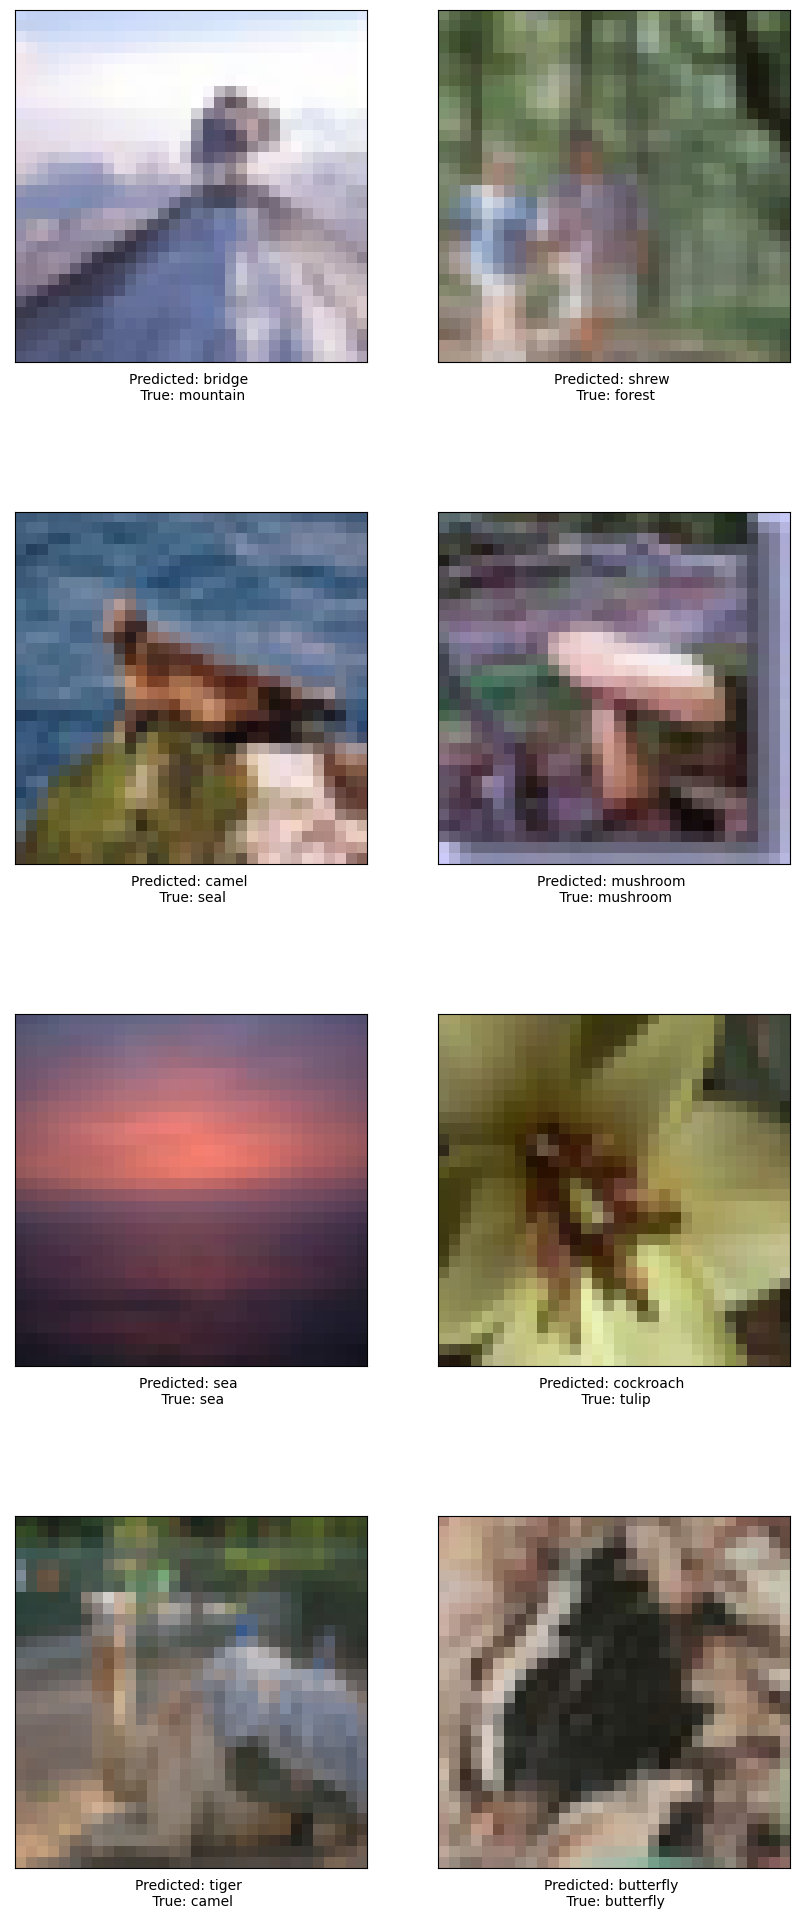

In [16]:
# Visualization X_test
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
    
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)

    pred = history.model.predict(X_test[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = np.argmax(y_test[i])

    color = 'blue' if pred_label == true_label else 'red'

    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label]}")
plt.show()